# カリフォルニア住宅価格予測

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import requests
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set(font="IPAexGothic")

from pathlib import Path
from sklearn.model_selection import train_test_split

from data_loader.data_loader import DataLoaderCaliforniaHousing

import lightgbm as lgb

## Prepare

In [3]:
url_base = f'http://{os.environ["AI_DASHBORARD_IPADDR"]}:1317/api/'
dataset_dir_base = '/tf/data'

In [4]:
project_list = requests.get(url_base+'get_project_list')
project_list.json()

[{'name': 'California', 'id': 1}]

In [5]:
dataset_list = requests.get(url_base+'get_dataset_list')
dataset_list.json()

[{'name': 'CaliforniaHousing',
  'project': 1,
  'dataset_dir_offset': 'ae5ce162888ee3ebe974976cac5ab94a3f55049f8515884883d579fb3fa378d2/dataset_3'},
 {'name': 'MNIST',
  'project': 1,
  'dataset_dir_offset': 'ae5ce162888ee3ebe974976cac5ab94a3f55049f8515884883d579fb3fa378d2/dataset_1'}]

## Load Dataset

In [6]:
dataset_dir = dataset_list.json()[0]['dataset_dir_offset']
dataloader = DataLoaderCaliforniaHousing(Path(dataset_dir_base, dataset_dir))

train_x = dataloader.train_x
train_y = dataloader.train_y
validation_x = dataloader.validation_x
validation_y = dataloader.validation_y
test_x = dataloader.test_x
test_y = dataloader.test_y

In [7]:
print(f'train_x shape: {train_x.shape}')

train_x shape: (16512, 8)


In [8]:
train_x

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25
...,...,...,...,...,...,...,...,...
16507,4.4213,11.0,7.345936,1.132325,1605.0,3.034026,37.74,-121.11
16508,3.3578,35.0,5.450000,0.973529,958.0,2.817647,37.80,-121.10
16509,4.1833,22.0,6.564232,1.035264,1252.0,3.153652,37.76,-121.11
16510,3.4426,7.0,5.416393,1.028415,3006.0,3.285246,37.73,-121.16


In [9]:
train_y

,TARGET
0,4.526
1,3.585
2,3.521
3,3.413
4,3.422
...,...
16507,1.827
16508,1.490
16509,1.921
16510,1.390


## Check Missing Value

In [10]:
dataloader.train_x.isnull().sum()

MedInc        0
HouseAge      0
AveRooms      0
AveBedrms     0
Population    0
AveOccup      0
Latitude      0
Longitude     0
dtype: int64

## Histogram

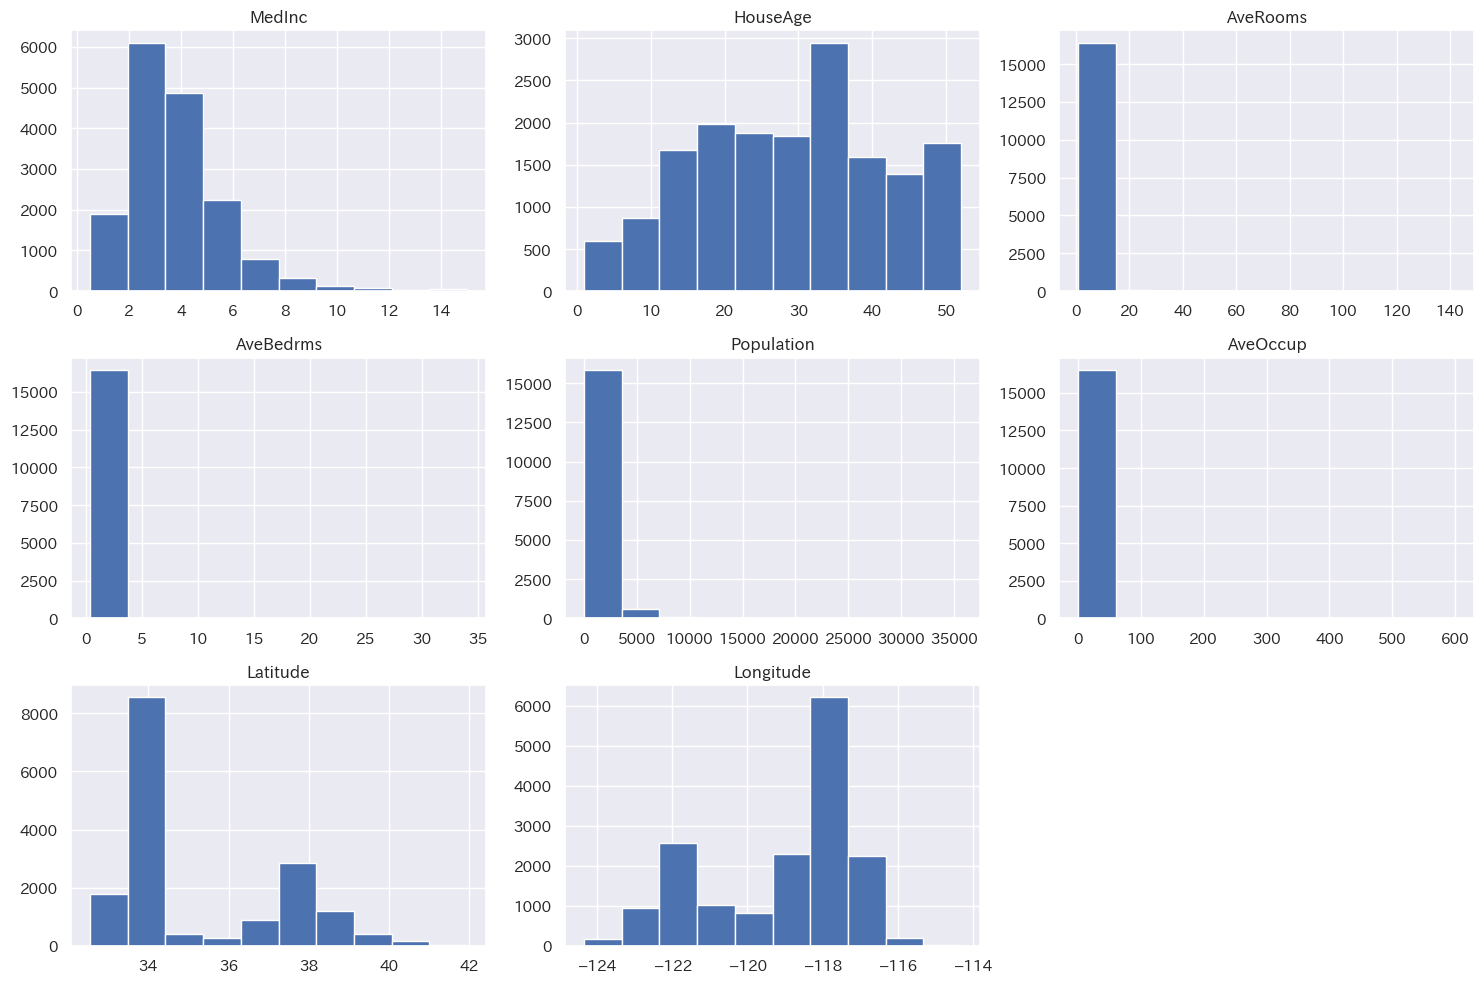

In [11]:
float_cols = train_x.columns[train_x.dtypes=='float64']
hist_data = train_x[float_cols]

hist_data.hist(figsize=(15, 10))
plt.tight_layout()
plt.show()
plt.close()

## Training

In [12]:
SEED = 0

params = {
    'objective': 'regression',
    'metric': 'mae',
    'num_leaves': 32,
    'max_depth': 4,
    "feature_fraction": 0.5,
    'subsample_freq': 1,
    "bagging_fraction": 0.8,
    'min_data_in_leaf': 5,
    'learning_rate': 0.01,
    "boosting": "gbdt",
    "lambda_l1": 1,
    "lambda_l2": 5,
    "verbosity": -1,
    "random_state": 42,
    "early_stopping_rounds": 100
}

train_data = lgb.Dataset(train_x, label=train_y)
validation_data = lgb.Dataset(validation_x, label=validation_y)
test_data = lgb.Dataset(test_x, label=test_y)

model = lgb.train(
    params,
    train_data, 
    valid_names = ['train', 'validation', 'test'],
    valid_sets = [train_data, validation_data, test_data], 
    num_boost_round = 50000,
    callbacks=[lgb.log_evaluation(period=100)]
)

[100]	train's l1: 0.594069	validation's l1: 0.699739	test's l1: 0.699739
[200]	train's l1: 0.466823	validation's l1: 0.607184	test's l1: 0.607184
[300]	train's l1: 0.40409	validation's l1: 0.577406	test's l1: 0.577406
[400]	train's l1: 0.373535	validation's l1: 0.571018	test's l1: 0.571018
[500]	train's l1: 0.354795	validation's l1: 0.570256	test's l1: 0.570256
